# Sentiment Analysis dengan Data Text menggunakan Bidirectional LSTM

Nama: Janice Ashley Kurniawan

NIM: 2602203794

## Code

In [1]:
# import library
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, F1Score

import warnings
import random
warnings.filterwarnings('ignore')
SEED_VALUE=123
random.seed(SEED_VALUE)

In [2]:
# extract zip
!unzip dataset.zip

Archive:  dataset.zip
  inflating: movie.csv               
  inflating: __MACOSX/._movie.csv    


In [3]:
# read dataset
df = pd.read_csv('movie.csv')

In [4]:
# show 5 row pertama dataset
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
# info column dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [6]:
# jumlah column dan row yang ada di dataset
df.shape

(40000, 2)

In [7]:
# check & show duplicated row
print(df.duplicated().sum())
print(df[df.duplicated()])

277
                                                    text  label
2164   I find it rather useless to comment on this "m...      0
3236   An absolutely atrocious adaptation of the wond...      0
3428   When I first saw this film it was not an impre...      0
3652   Before I watched this tv movie I did not know ...      1
3787   What a clunker!<br /><br />It MUST have been m...      0
...                                                  ...    ...
39229  I Enjoyed Watching This Well Acted Movie Very ...      1
39246  You do realize that you've been watching the E...      0
39508  (Spoilers)<br /><br />Oh sure it's based on Mo...      0
39681  It's been a long time since I last saw a movie...      0
39746  Goodnight, Mister Tom begins in an impossibly ...      0

[277 rows x 2 columns]


In [8]:
# drop & check duplicated row
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

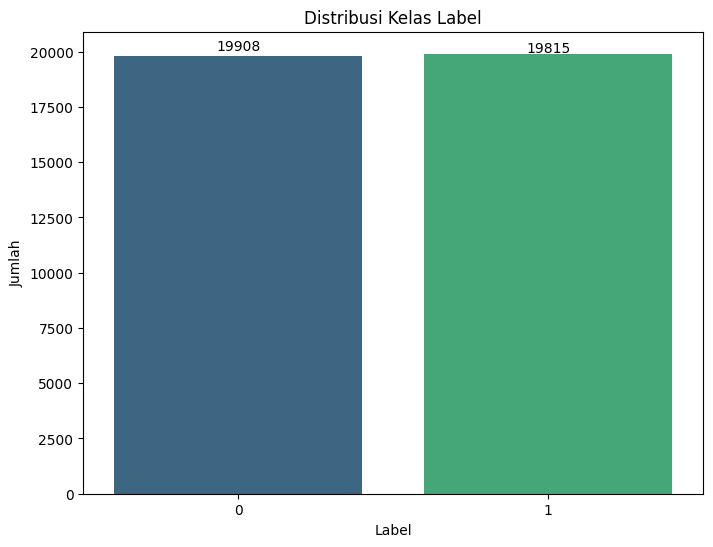

In [9]:
# barplot distribusi kelas label
import matplotlib.pyplot as plt
import seaborn as sns

label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df, palette='viridis')
plt.title('Distribusi Kelas Label')
plt.xlabel('Label')
plt.ylabel('Jumlah')

for i, count in enumerate(label_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

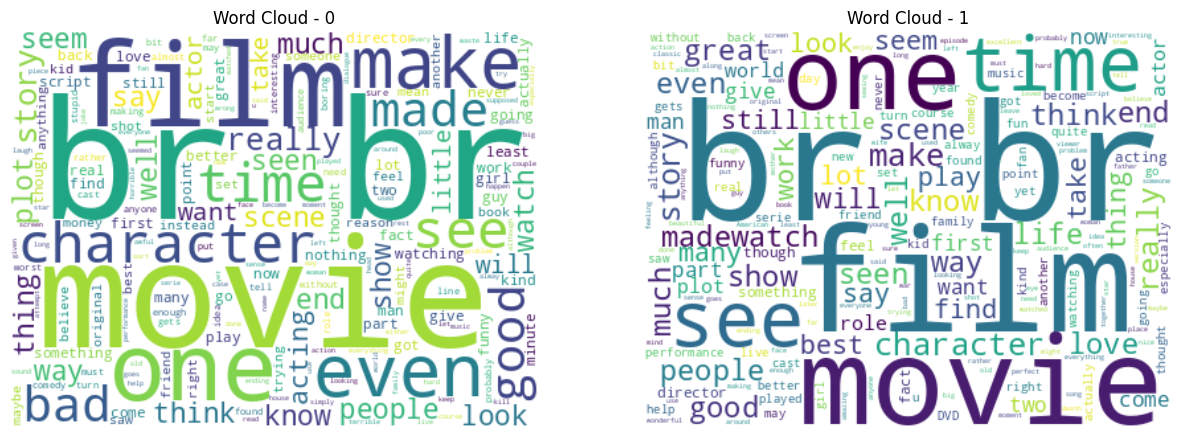

In [10]:
# wordcloud untuk masing-masing kelas label
from wordcloud import WordCloud

text_combined = {}
for label in df['label'].unique():
    text_combined[label] = " ".join(df[df['label'] == label]['text'])

plt.figure(figsize=(15, 6))
for i, label in enumerate(df['label'].unique(), 1):
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text_combined[label])
    plt.subplot(1, len(df['label'].unique()), i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {label}')
    plt.axis('off')

plt.show()

In [11]:
# data preprocessing
import nltk
import re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# function untuk menghapus tanda baca
def remove_punctuation(words):
    return [word for word in words if word not in punctuation]

# function untuk menghapus '<br>'
def remove_br(words):
    return [word for word in words if word != 'br']

# function untuk menghapus kata-kata non-alfabet
def remove_non_alpha(words):
    return [word for word in words if word.isalpha()]

# function untuk menghapus stopwords
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

# function untuk lemmatization
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# function utama untuk preprocess text
def preprocess_text(text):
    # lowercase
    text = text.lower()
    # tokenization
    words = word_tokenize(text)

    words = remove_punctuation(words)
    words = remove_br(words)
    words = remove_non_alpha(words)
    words = remove_stopwords(words)
    words = lemmatize_words(words)

    return ' '.join(words)

# apply function pada dataset
df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
# show text before after preprocess
df[['text', 'clean_text']].head()

,text,clean_text
0,I grew up (b. 1965) watching and loving the Th...,grew b watching loving thunderbird mate school...
1,"When I put this movie in my DVD player, and sa...",put movie dvd player sat coke chip expectation...
2,Why do people who do not know what a particula...,people know particular time past like feel nee...
3,Even though I have great interest in Biblical ...,even though great interest biblical movie bore...
4,Im a die hard Dads Army fan and nothing will e...,im die hard dad army fan nothing ever change g...


In [13]:
# show text before after preprocess secara spesifik row 1833
row_index = 1833
print("original text:\n", df.loc[row_index, 'text'])
print("\ntext after preprocessing:\n", df.loc[row_index, 'clean_text'])

original text:
 What a clunker!<br /><br />It MUST have been made for TV or Cable.<br /><br />Look: forget the screenplay - forget the bunch of forgettable actors. Excuse me? Continuity? The NSA/NIA/whatever or whoever he is (an agent) takes-off in an F16 - is shown in an F18 chucking his guts up and, later, the aircraft shown taxiing is an F4 Phantom! Oooh, wish that I could be so cavalier.<br /><br />Apart from the male actors(!?) The women are WASPS: blue-eyed and long-legged and, eventually, get to cry about the heroes who save them. Even when a solid weld could save most of the cosmo- astro-nauts, the blond drops the welding tool. Duh!<br /><br />As an SF movie one out of ten. As a movie per se: 1/2 (that's a half point). They should have ditched the space station and headed for Mars.<br /><br />Major raspberries.

text after preprocessing:
 clunker must made tv look forget screenplay forget bunch forgettable actor excuse continuity whoever agent shown chucking gut later aircraft 

In [14]:
# texts = df['clean_text'].values
# labels = df['label'].values

In [15]:
# text tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_text'])

In [16]:
import os
import pickle

# make directory
model_dir = '/content/models'
os.makedirs(model_dir, exist_ok=True)

# save tokenizer
tokenizer_path = os.path.join(model_dir, 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
# determine X and y
X = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(X, maxlen=200)
y = df['label'].astype('float32')

In [18]:
# split data menjadi 80% train 10% test dan 10% vaidation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

print(f'samples for training: {len(X_train)}')
print(f'samples for testing: {len(X_test)}')
print(f'samples for validation: {len(X_val)}')

samples for training: 31778
samples for testing: 3972
samples for validation: 3973


In [19]:
# model Bidirectional LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=200))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32)))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))  # output layer untuk binary classification

In [20]:
# model architecture summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 bidirectional (Bidirection  (None, 200, 128)          98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [21]:
# compile model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(), Precision(), Recall(), F1Score()])

In [22]:
# train model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
497/497 [==============================] - 57s 95ms/step - loss: 0.3707 - binary_accuracy: 0.8343 - precision: 0.8218 - recall: 0.8543 - f1_score: 0.6673 - val_loss: 0.3033 - val_binary_accuracy: 0.8757 - val_precision: 0.8851 - val_recall: 0.8676 - val_f1_score: 0.6732
Epoch 2/10
497/497 [==============================] - 24s 48ms/step - loss: 0.2535 - binary_accuracy: 0.9004 - precision: 0.8960 - recall: 0.9062 - f1_score: 0.6673 - val_loss: 0.3311 - val_binary_accuracy: 0.8754 - val_precision: 0.8565 - val_recall: 0.9062 - val_f1_score: 0.6732
Epoch 3/10
497/497 [==============================] - 20s 41ms/step - loss: 0.2043 - binary_accuracy: 0.9233 - precision: 0.9205 - recall: 0.9269 - f1_score: 0.6673 - val_loss: 0.3622 - val_binary_accuracy: 0.8648 - val_precision: 0.8978 - val_recall: 0.8279 - val_f1_score: 0.6732
Epoch 4/10
497/497 [==============================] - 19s 39ms/step - loss: 0.1680 - binary_accuracy: 0.9376 - precision: 0.9358 - recall: 0.9397 - f1_sco

In [23]:
# save model
model_path = os.path.join(model_dir, 'trained_model.h5')
model.save(model_path)

In [24]:
# make predictions on test data
predictions = model.predict(X_test)

125/125 [==============================] - 3s 11ms/step


In [25]:
# evaluate model using loss, accuracy, precision, recall, and f1_score
loss, accuracy, precision, recall, f1_score = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')

125/125 [==============================] - 2s 12ms/step - loss: 0.5602 - binary_accuracy: 0.8560 - precision: 0.8442 - recall: 0.8724 - f1_score: 0.6658
Loss: 0.5602209568023682, Accuracy: 0.8559919595718384, Precision: 0.84423828125, Recall: 0.8723511695861816, F1 Score: [0.66577095]


In [26]:
# load saved model
from tensorflow.keras.models import load_model

model_path = '/content/models/trained_model.h5'
model = load_model(model_path)

tokenizer_path = '/content/models/tokenizer.pkl'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [28]:
# test model using new reviews
new_reviews = [
    "I absolutely loved the latest Marvel movie! The action sequences were mind-blowing, and the storyline kept me engaged from start to finish.",
    "I found the new romantic comedy to be quite disappointing. The plot was predictable, and the characters lacked depth, making it hard to connect with the story.",
]

preprocessed_reviews = [preprocess_text(review) for review in new_reviews]

sequences = tokenizer.texts_to_sequences(preprocessed_reviews)
padded_sequences = pad_sequences(sequences, maxlen=200)  # Sesuaikan dengan maxlen yang digunakan saat melatih model

predictions = model.predict(padded_sequences)

results = []
for i, prediction in enumerate(predictions):
    sentiment = 'positive' if prediction >= 0.5 else 'negative'
    results.append((new_reviews[i], sentiment))

for review, sentiment in results:
    print(f"Review: {review}")
    print(f"Sentiment: {sentiment}")
    print()

1/1 [==============================] - 0s 41ms/step
Review: I absolutely loved the latest Marvel movie! The action sequences were mind-blowing, and the storyline kept me engaged from start to finish.
Sentiment: positive

Review: I found the new romantic comedy to be quite disappointing. The plot was predictable, and the characters lacked depth, making it hard to connect with the story.
Sentiment: negative



## Penjelasan

### Dataset
Pada project ini, saya menggunakan dataset "IMDB Movie Ratings Sentiment Analysis" dari Kaggle (https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/data). Dataset ini terdiri dari 40.000 review sample mengenai IMDB Movie Ratings dengan dua column, yaitu text (review) dan label (0 = negative review dan 1 = positive review). Kemudia, dataset dibagi menjadi tiga set: train 80%, test 10%, dan validation 10%.

### Model
Model yang digunakan adalah Bidirectional LSTM. Saya menggunakan model tersebut karena ia mampu menangkap informasi dari kedua arah dalam urutan data text, yaitu dari awal ke akhir dan dari akhir ke awal. Hal ini penting untuk Sentiment Analysis karena konteks kalimat dapat dipengaruhi oleh kata-kata yang muncul sebelumnya maupun sesudahnya. Dengan memproses text dalam dua arah, model dapat memahami konteks dengan lebih baik, yang juga dapat meningkatkan akurasi dalam menentukan sentimen positif atau negatif. Evaluation metrics yang digunakan dalam case binary classification ini adalah binary cross-entropy loss, binary accuracy, precision, recall, dan F1 score.

### Analisis Performance di Train, Val, dan Test Set

##### Train Set
- Loss: 0.0624
- Binary Accuracy: 0.9813
- Precision: 0.9801
- Recall: 0.9827
- F1 Score: 0.9814
- Interpretasi: Model memiliki kinerja yang sangat baik pada data train dengan Binary Accuracy dan F1-Score yang sangat tinggi. Hal ini menunjukkan bahwa model mampu menangkap pola dalam data train dengan sangat baik.

##### Validation Set
- Loss: 0.6598
- Binary Accuracy: 0.8402
- Precision: 0.8357
- Recall: 0.8527
- F1 Score: 0.8441
- Interpretasi: Pada data validation, terdapat penurunan performa dibandingkan dengan data train. Hal ini menunjukkan adanya overfitting, di mana model terlalu menyesuaikan dengan data train dan kurang mampu menangani data baru.

##### Test Set
- Loss: 0.5602
- Binary Accuracy: 0.8560
- Precision: 0.8442
- Recall: 0.8724
- F1 Score: 0.8580
- Interpretasi: Kinerja model pada data test menunjukkan bahwa model memiliki kemampuan generalisasi yang baik terhadap data baru yang belum pernah dilihat sebelumnya, meskipun ada penurunan performa dibandingkan dengan data train.

##### Kesimpulan
- Overfitting -> terjadi overfitting yang terlihat dari penurunan performa antara train dan validation/test set.
- Generalization -> model memiliki kemampuan generalisasi yang cukup baik pada data test, namun masih dapat dilakukan perbaikan untuk mengatasi overfitting.

### Motivasi/Urgency Case
Sentiment Analysis pada review menganai IMDB Movie Ratings penting dan dapat digunakan untuk:
- Pengalaman Pengguna -> platform seperti IMDB dapat memberikan rekomendasi film yang lebih personal kepada pengguna berdasarkan sentimen review mereka.
- Meningkatkan Kualitas Konten -> produser dan penulis dapat menggunakan analisis sentimen untuk mendapatkan umpan balik dan meningkatkan kualitas konten di masa mendatang.
- Mengoptimalkan Pemasaran -> memahami sentimen penonton dapat membantu produser film dan pemasar dalam menyusun strategi pemasaran yang lebih efektif.

### Future Directions
Hal-hal yang dapat dilakukan untuk memperbaiki model:
- Hyperparameter Tuning -> melakukan tuning hyperparameter yang lebih mendalam untuk model Bidirectional LSTM untuk meningkatkan performa dan mengurangi overfitting.
- Model Ensembles -> menggabungkan beberapa model untuk meningkatkan akurasi prediksi.
- Transfer Learning -> menggunakan pretrained model seperti BERT atau GPT untuk meningkatkan performa pada task Sentiment Analysis.
- Data Augmentation -> meningkatkan jumlah dan variasi data training dengan teknik augmentasi data.
- Real-time Analysis -> membangun sistem Sentiment Analysis real-time yang dapat digunakan untuk memproses dan menganalisis review secara langsung.

### Referensi
- https://github.com/wllchrst/qualif-NaturalLanguageProcessing/blob/main/NaturalLanguageProcessing_Answer_Case1.ipynb
- https://www.kaggle.com/code/maulikjain26/sentiment-analysis-using-bidirectional-lstm
- https://www.kaggle.com/code/ngyptr/lstm-sentiment-analysis-keras